## Load the necessary imports

In [10]:
from __future__ import annotations


import sys

sys.path.append("../scripts")

In [11]:
from tqdm import tqdm
from preprocessing import simple_thresholding, adaptive_thresholding
import itertools
from testy import count_black_pixels, convert_slice_stats_to_csv, convert_volume_stats_to_csv, comparison_plot, apply_equalization_and_stretching
from wup_analysis import initialize_dataset, DATA_PATH_TEMPLATE, update_slice_stats, update_volume_stats
import cv2
from matplotlib import pyplot as plt
import numpy as np

## Implementation of helper functions for the image preprocessing

In [12]:
def thresh_refinement(img, plot=False):
    # Define the size threshold to filter out small speckles
    min_region_size = 12  # Adjust this value as needed

    # Erosion to remove small speckles
    kernel = np.ones((3, 1), np.uint8)
    eroded_image = cv2.erode(img, kernel, iterations=1)

    # Convert the eroded image to CV_8U data type
    eroded_image = eroded_image.astype(np.uint8)

    # Connected Component Analysis to label regions
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded_image, connectivity=8)

    # Filter regions by size
    filtered_image = np.zeros(eroded_image.shape, dtype=np.uint8)
    for i in range(1, num_labels):  # Skip the background label (0)
        region_size = stats[i, cv2.CC_STAT_AREA]
        if region_size >= min_region_size:
            filtered_image[labels == i] = 255

    if plot:
        plt.figure(figsize=(8, 8))
        plt.imshow(filtered_image, cmap='gray')
        plt.title("white_area_mask")
        plt.axis('off')
        plt.show()
        
    return filtered_image

In [13]:
def extract_crop_coordinates(img):
    # Get the dimensions of the image
    height, width = img.shape

    # Iterate through each pixel and append its value to the list
    for y, x in itertools.product(range(height), range(width)):
        pixel_value = img[y, x]

        if pixel_value > 240:
            return y, x

In [14]:
def match_image_dimensions(image1, image2):
    # Get the dimensions of the first image
    height1, width1 = image1.shape

    # Get the dimensions of the second image
    height2, width2 = image2.shape

    # Calculate the dimensions of the padded image
    target_height = max(height1, height2)
    target_width = max(width1, width2)

    # Create a new image with the dimensions of the padded image and fill it with white
    padded_image = np.ones((target_height, target_width), dtype=np.uint8) * 255

    # Paste the second image onto the padded image
    padded_image[:height2, :width2] = image2

    return padded_image


In [15]:
def cropped_image(img, plot=False):
    enhanced_img = apply_equalization_and_stretching(img)
    thresh_img = simple_thresholding(enhanced_img, thresh_value=250)
    refined_img = thresh_refinement(thresh_img)
    cutoff_row, _ = extract_crop_coordinates(refined_img)
    cropped_image = img[:cutoff_row, :]

    cropped_image_with_padding = match_image_dimensions(img, cropped_image)
    if plot:
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot the grayscale image in the first subplot
        axes[0].imshow(img, cmap='gray')
        axes[0].axhline(y=cutoff_row, color='r', linestyle='--', label='Cropping Line')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[0].legend()

        # Plot the stretched image in the second subplot
        axes[1].imshow(cropped_image_with_padding, cmap='gray')
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')

        # Adjust the spacing between the subplots
        plt.tight_layout()

        # Display the plots
        plt.show()

    return cropped_image

In [16]:
def apply_morphology_operations(image, kernel_size_opening=(1, 2), kernel_size_closing=(1, 9), threshold_value=200):
    # Apply morphological operation to remove vertical lines
    kernel_opening = np.ones(kernel_size_opening, np.uint8)
    no_lines = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_opening)

    # Apply thresholding based on histogram analysis
    _, thresholded_image = cv2.threshold(no_lines, threshold_value, 255, cv2.THRESH_BINARY)

    # Define the kernel for morphological operations
    kernel_closing = np.ones(kernel_size_closing, np.uint8)

    # Apply erosion to remove small white speckles
    eroded_image = cv2.erode(thresholded_image, kernel_closing, iterations=1)

    # Apply dilation to fill small gaps
    dilated_image = cv2.dilate(eroded_image, kernel_closing, iterations=1)
    
    # Display the results
    cv2.imshow('Original Thresholded Image', thresholded_image)
    cv2.imshow('After Erosion', eroded_image)
    cv2.imshow('After Dilation', dilated_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return no_lines, thresholded_image, dilated_image

In [17]:
def preprocess_img(img, plot=False):
    _, _, processed_img = apply_morphology_operations(img)
    
    # Compute the convex hull
    chull = convex_hull_image(processed_img)

    # Invert the convex hull mask
    inverted_chull = np.where(chull == 0, 255, 0).astype(np.uint8)
    
    # # Define the kernel for dilation
    # kernel = np.ones((15, 15), np.uint8)

    # # Apply dilation to the binary image
    # inverted_chull_with_border = cv2.erode(inverted_chull, kernel, iterations=3)
    
    
    # comparison_plot(inverted_chull_with_border, inverted_chull, "Convex Hull", "Inverted Convex Hull")

    # Subtract the contour mask from the input image
    subtracted_img = cv2.subtract(inverted_chull, img)

    # Invert the subtracted image
    inverted_img = cv2.bitwise_not(subtracted_img)

    # Replace white pixels with a specific value (38 in this case)
    inverted_img[inverted_img == 255] = 38

    # Apply adaptive thresholding
    tmp = adaptive_thresholding(inverted_img, block_size=233, constant_offset=84)
    # tmp = adaptive_thresholding(inverted_img, block_size=33, constant_offset=43)
    # tmp = adaptive_thresholding(inverted_img, block_size=201, constant_offset=50)

    # Define a kernel for morphological operations
    kernel = np.ones((2, 20), np.uint8)

    # Perform closing operation
    closed_image = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)

    if plot:
        comparison_plot(img, closed_image, "Original Image", "Processed Image")

    return closed_image

## Main function for the 2D image analysis

In [21]:
def run_analysis(data: list[np.ndarray], dataset: str, save: bool = False) -> None:
    """
    Perform analysis on the given dataset.

    :param data: List of numpy arrays representing the dataset.
    :param dataset: Name of the dataset.
    :param save: Whether to save the analysis results or not. Defaults to False.
    :return: None
    """

    slice_stats = {}
    min_init, max_init = float('inf'), 0
    volume_stats = {
        'min_air_pockets': min_init,
        'max_air_pockets': max_init,
        'min_air_pocket_size': min_init,
        'max_air_pocket_size': max_init,
        'min_black_pixel_count': min_init,
        'max_black_pixel_count': max_init,
        'min_air_pocket_percentage': min_init,
        'max_air_pocket_percentage': max_init,
    }

    for img in tqdm(data, total=len(data)):
        center_x = img.shape[1] // 2
        center_y = img.shape[0] // 2
        crop = cropped_image(img)
        thresh = adaptive_thresholding(crop, block_size=33, constant_offset=43)
        volume_black_pixel_count = count_black_pixels(thresh)
        inverted_img = cv2.bitwise_not(thresh)

        num_labels, _, stats, centroids = cv2.connectedComponentsWithStats(inverted_img, connectivity=8)

        slice_stats, areas, max_area, min_area = update_slice_stats(slice_stats, num_labels, stats, center_x, center_y, centroids)
        volume_stats = update_volume_stats(volume_stats, num_labels, min_area, max_area, volume_black_pixel_count, areas)

    volume_stats['min_air_pocket_depth'] = min(dct.get('depth') for dct in slice_stats.values())
    volume_stats['max_air_pocket_depth'] = max(dct.get('depth') for dct in slice_stats.values())


    if save:
        convert_slice_stats_to_csv(slice_stats,f'../data/aske/{dataset}/csv_files/slice_stats')
        convert_volume_stats_to_csv(volume_stats, f'../data/aske/{dataset}/csv_files/volume_stats')

    return slice_stats, volume_stats

## Start the analysis

In [19]:
dataset = 'WUP3'
path = DATA_PATH_TEMPLATE.format(dataset.lower())
DATA = initialize_dataset(path, dataset, width=1028, save=True)

In [22]:
run_analysis(DATA, dataset=dataset.lower(), save=True)

100%|██████████| 1480/1480 [13:51<00:00,  1.78it/s]


({'484-6': {'area': [6, 11, 46, 43],
   'aspect_ratio': [0.4, 0.2857, 0.16, 0.1667],
   'dispersion': [505.8966, 506.0941, 506.416, 506.4437],
   'depth': 4},
  '619-17': {'area': [5, 2],
   'aspect_ratio': [0.6667, 0.5],
   'dispersion': [506.2114, 506.5385],
   'depth': 2},
  '605-20': {'area': [29, 29, 2],
   'aspect_ratio': [0.0909, 0.0909, 0.5],
   'dispersion': [500.404, 500.3251, 500.8056],
   'depth': 3},
  '419-45': {'area': [1, 3, 2],
   'aspect_ratio': [1.0, 1.0, 0.5],
   'dispersion': [476.1701, 475.7134, 476.0727],
   'depth': 3},
  '598-53': {'area': [1, 2],
   'aspect_ratio': [1.0, 0.5],
   'dispersion': [466.9872, 467.0795],
   'depth': 2},
  '329-57': {'area': [39, 42, 46, 20],
   'aspect_ratio': [0.1875, 0.1765, 0.2222, 0.1667],
   'dispersion': [490.3126, 490.2493, 490.0702, 489.7158],
   'depth': 4},
  '361-57': {'area': [7, 10],
   'aspect_ratio': [0.1429, 0.2222],
   'dispersion': [479.4017, 479.0554],
   'depth': 2},
  '688-65': {'area': [88, 1, 15],
   'aspect_r

In [346]:
seg1 = preprocess_img(DATA[0])

crop = cropped_image(DATA[0], plot=True)
seg2 = adaptive_thresholding(crop, block_size=33, constant_offset=43, plot=True)

comparison_plot(seg1, seg2, "Segmented Image 1", "Segmented Image 2")


error: OpenCV(4.8.1) /io/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


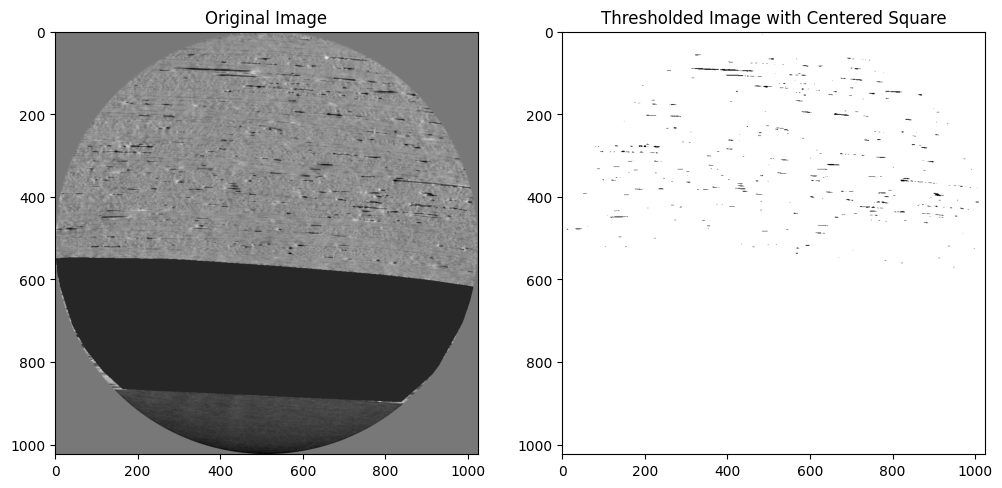

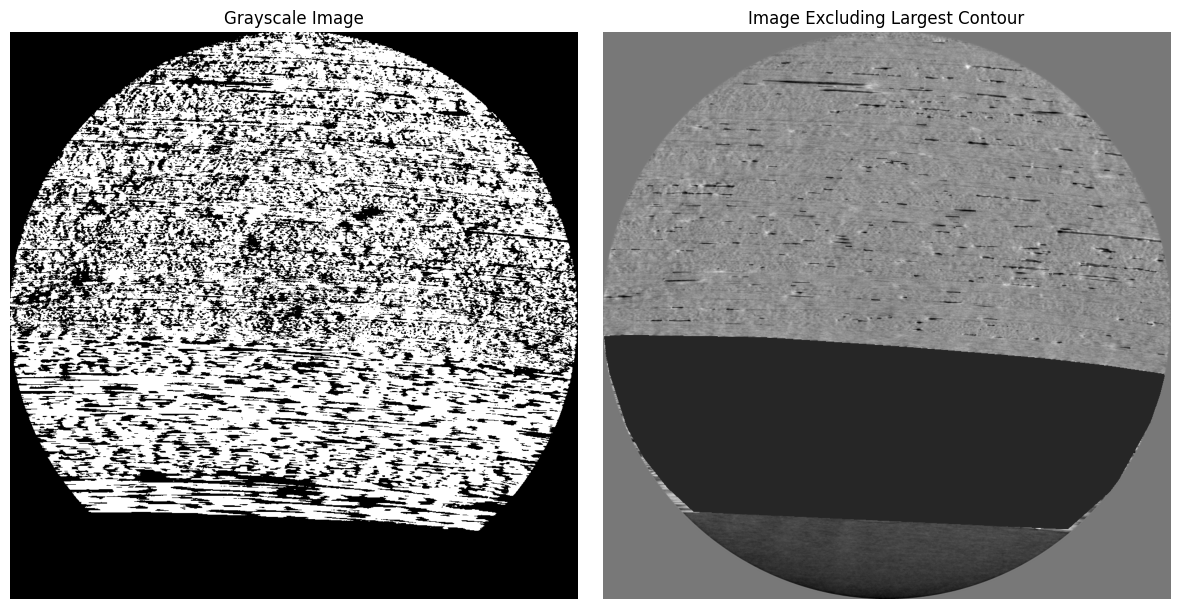

In [302]:
thresh = otsu_thresholding(DATA[0])
# Subtract the largest contour mask from the input image
new_img = cv2.subtract(inverted_chull, DATA[0])
x = cv2.bitwise_not(new_img)
x[x == 255] = 38
# tmp = otsu_thresholding(x, plot=True)
tmp = adaptive_thresholding(x, block_size=233, constant_offset=84, plot=True)

comparison_plot(thresh, x, "Grayscale Image", "Image Excluding Largest Contour")

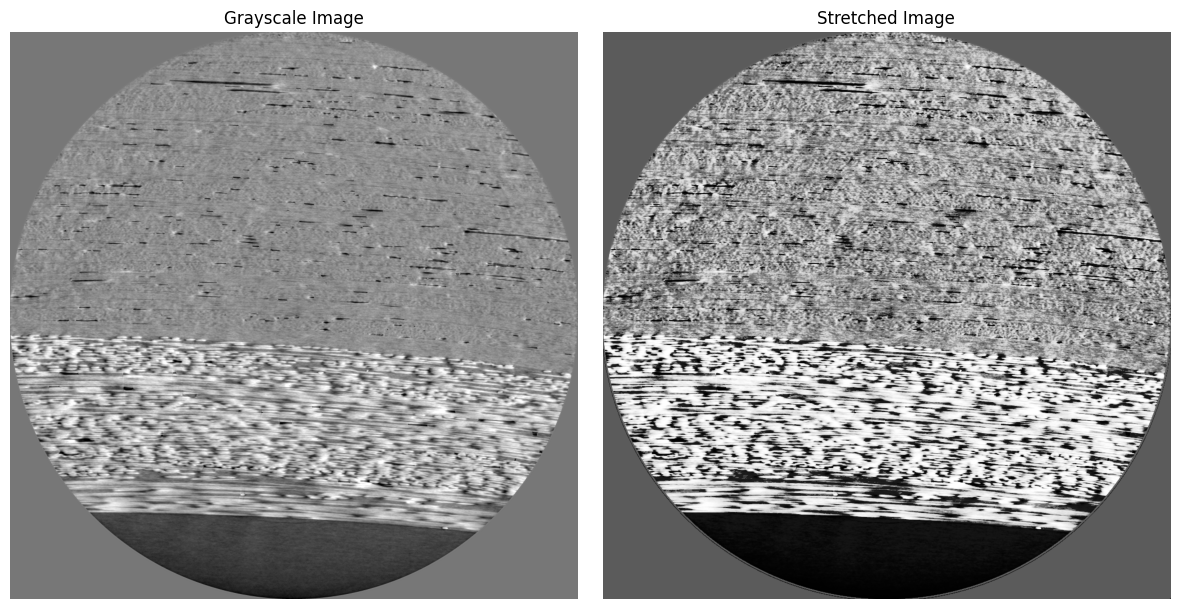

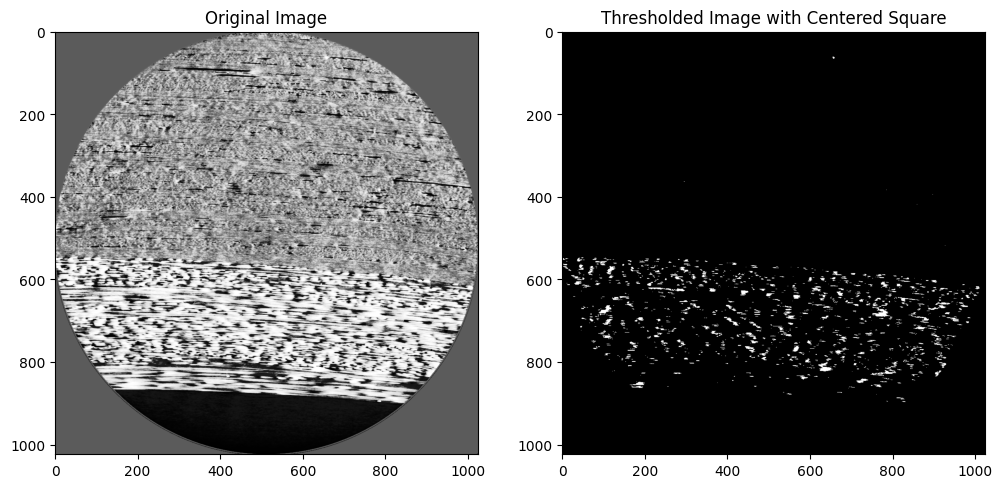

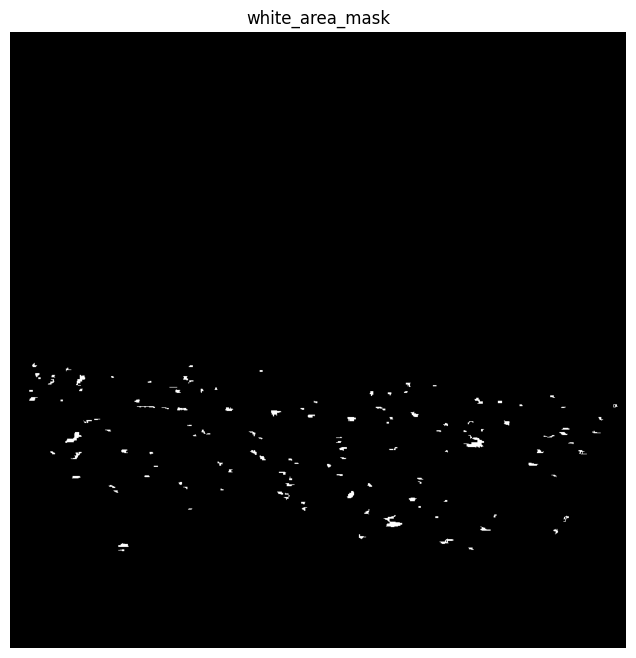

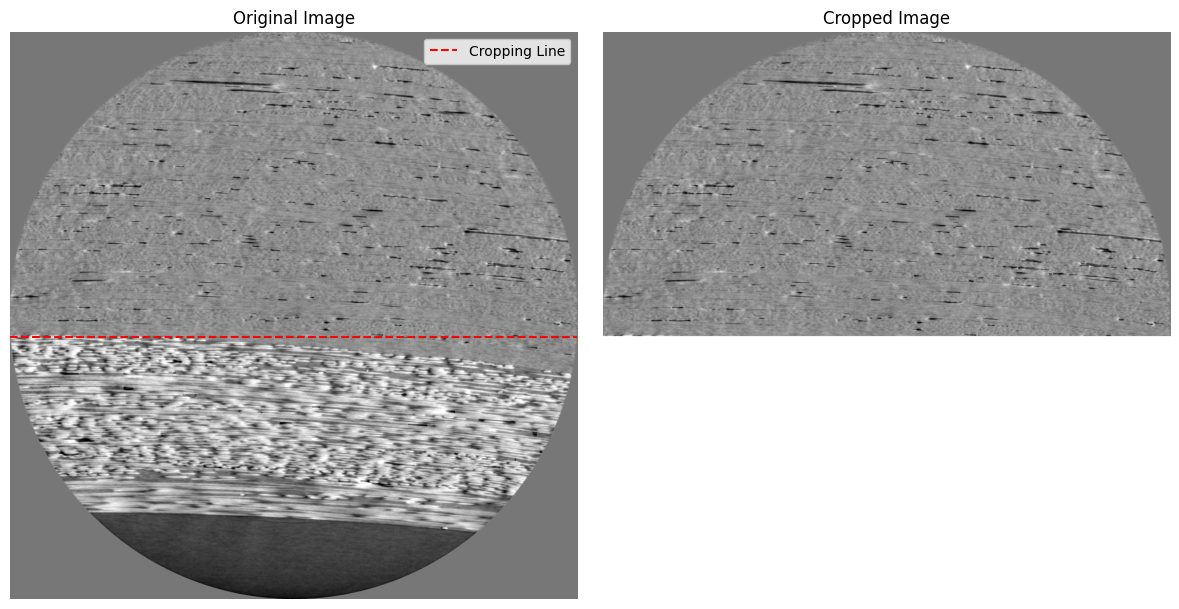

array([[119, 119, 119, ..., 119, 119, 118],
       [119, 119, 119, ..., 119, 119, 119],
       [119, 119, 119, ..., 119, 119, 119],
       ...,
       [124, 141, 142, ..., 141, 130, 123],
       [124, 172, 162, ..., 140, 131, 123],
       [123, 201, 202, ..., 129, 127, 123]], dtype=uint8)

In [40]:
cropped_image(DATA[0], plot=True)

In [ ]:
# run_analysis(DATA, dataset=dataset.lower(), save=True)

## Test to randomly apply the postprocessing to a series of images -> Used for visual inspection

In [ ]:
# import random

# # Assuming you want to select, for example, 5 random images from the list
# subset_size = 30

# # Randomly select indices for the subset
# subset_indices = random.sample(range(len(DATA)), subset_size)

# # Create a list of images from the selected indices
# random_subset = [(DATA[i], i) for i in subset_indices]

# for img, i in random_subset:
#     print(i)
#     cropped_image(img, plot=True)


In [ ]:
# tmp = adaptive_thresholding(img, block_size=33, constant_offset=43, plot=True)

In [ ]:
# inverted_img = cv2.bitwise_not(tmp)

In [ ]:
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inverted_img, connectivity=8)

In [ ]:
# min_area_threshold = 100  # Adjust as needed
# line_mask = np.where(stats[1:, cv2.CC_STAT_AREA] >= min_area_threshold, 255, 0).astype(np.uint8)

In [ ]:
# contours, _ = cv2.findContours(line_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# len(num_labels)

In [ ]:
# # Create a copy of the original image for visualization
# original_image_copy = tmp.copy()

# # Draw contours on the copy of the original image
# cv2.drawContours(original_image_copy, contours, -1, (0, 0, 255), 2)  # Red color, line width = 2

# # Display the image with contours
# plt.figure(figsize=(8, 8))
# plt.imshow(original_image_copy)
# plt.title("Image with Contours")
# plt.axis('off')
# plt.show()

In [ ]:
# stats_dct = {}
# for i in range(num_labels):

#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP]
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]
#     centroid = str(cX) + str(cY)

#     # area, dispersion, aspect ratio, depth incremental
#     stats_dct[centroid] = {'area': area}
#     stats_dct[centroid] = {'aspect_ratio': h / w}

# total_stats = {}
# total_stats['num_air_pockets'] = len(num_labels)
# total_stats['min_air_pocket_size'] = min(stats_dct.get('area'))
# total_stats['max_air_pocket_size'] = max(stats_dct.get('area'))
# total_stats['total_volume'] = compute_total_pixel_volume()


In [ ]:
# # Determine the original dimensions of your 4K monitor
# monitor_width = 3840  # 4K resolution width

# for i in range(num_labels):

#     x = stats[i, cv2.CC_STAT_LEFT]
#     y = stats[i, cv2.CC_STAT_TOP]
#     w = stats[i, cv2.CC_STAT_WIDTH]
#     h = stats[i, cv2.CC_STAT_HEIGHT]
#     area = stats[i, cv2.CC_STAT_AREA]
#     (cX, cY) = centroids[i]

#     # Initialize text
#     text = f"examining component {i + 1}/{num_labels}, with area: {area}"

#     # Print a status message update for the current connected component
#     print(f"[INFO] {text}")

#     # Clone our original image (so we can draw on it) and then draw
#     # a bounding box surrounding the connected component along with
#     # a circle corresponding to the centroid
#     output = cv2.cvtColor(tmp, cv2.COLOR_GRAY2BGR)
#     cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
#     cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)

#     # Construct a mask for the current connected component by
#     # finding pixels in the labels array that have the current
#     # connected component ID
#     componentMask = (labels == i).astype("uint8") * 255

#     # Calculate the new width for both images (half of the monitor width)
#     new_width = monitor_width // 2

#     # Resize the images while maintaining the aspect ratio
#     output = cv2.resize(output, (new_width, int(output.shape[0] * (new_width / output.shape[1]))))
#     componentMask = cv2.resize(componentMask, (new_width, int(componentMask.shape[0] * (new_width / componentMask.shape[1]))))

#     # Show the output image and connected component mask
#     cv2.imshow("Resized Output", output)
#     cv2.imshow("Resized Connected Component", componentMask)
#     cv2.waitKey(0)

# # Close OpenCV windows
# cv2.destroyAllWindows()

In [ ]:
# DATA = np.expand_dims(DATA, axis=1)

In [ ]:
# visualize_point_cloud(DATA[:100], thrs=[20,20,20,20], vis_tool="pyvista")